# Challenge T2 - Group 19

Content:
1. Text stemming
2. Clustering and interpretation
3. Classification and prediction

In [14]:
"""
It takes one or two hours to finish the clustering with all the data,
if you want to test the code,
just take like the first 3000 or so ones.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
import string
import stop_words
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

"""
To use the two packages of nltk, do 
nltk.download("stopwords")
and
nltk.download('punkt')
in the python console
after you've installed nltk
if you don't want certain word that appears but not filtered by me,
add it in the list ['', '’', '``', '\'\'', '»', '...','«', 'nan', '--']
in the 3rd line of the get_stop_words() function
"""

def get_stop_words():
    stemmer = FrenchStemmer()
    custom_stop_words = set(stopwords.words('french') +
                            list(string.punctuation) +
                            ['', '’', '``', '\'\'', '»', '...','«',
                             'nan', '--', 'oui', 'non', 'franc', 'faut'] +
                            stop_words.get_stop_words('fr'))
    custom_stop_words = [stemmer.stem(word) for word in custom_stop_words]
    return custom_stop_words


def tokenize(text):
    stemmer = FrenchStemmer()
    words_temp = word_tokenize(text, language='french')
    words_no_prefix = [f[2:] if f.startswith(("l\'","d\'","j\'","n\'","c\'")) else f for f in words_temp]
    words_no_prefix = [f[3:] if f.startswith(("qu\'")) else f for f in words_no_prefix]
    words_prefect = [stemmer.stem(word) for word in words_no_prefix if not word.isdigit()]
    return words_prefect

## 1. Stemming

In [ ]:
# choose the file
file_names = ["DEMOCRATIE_ET_CITOYENNETE.csv", "LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.csv",
            "LA_TRANSITION_ECOLOGIQUE.csv", "ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.csv"]
file_name = file_names[0] # name of the file

We have two ways to get training data, either to load the matrix from the file already preprocessed, or to load the original data and do the preprocessing.

### Preprocessing

In [3]:
df = pd.read_csv("data/" + file_name, low_memory=False)
n_questions= df.shape[1] - 11 # 11 features are basic information
n_answers = df.shape[0]

#Use this of you only want to do one certain question

'''
answers = df["QUXVlc3Rpb246MTA3 - En qui faites-vous le plus confiance pour vous faire représenter dans la société et pourquoi ?"]
answers = answers.str.lower()
answers = answers.values.tolist()
answers = [x for x in answers if type(x) is str]
'''

#Use this if you want to combine the responses of all the questions
answers = df.iloc[:,11:]
answers = answers.astype(str)
answers = answers.apply(" ".join, axis =1)
answers = answers.str.lower()
answers = answers.values.tolist()

In [5]:
get_stop_words()

{'',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '...',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '``',
 'a',
 'ai',
 'aie',
 'aient',
 'aies',
 'ait',
 'alors',
 'as',
 'au',
 'aucun',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aussi',
 'autre',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'bon',
 'c',
 'car',
 'ce',
 'ceci',
 'cela',
 'ces',
 'cet',
 'cette',
 'ceux',
 'chaque',
 'ci',
 'comme',
 'comment',
 'd',
 'dans',
 'de',
 'dedans',
 'dehors',
 'depuis',
 'des',
 'deux',
 'devoir',
 'devrait',
 'devrez',
 'devriez',
 'devrions',
 'devrons',
 'devront',
 'dois',
 'doit',
 'donc',
 'dos',
 'droite',
 'du',
 'dès',
 'début',
 'dù',
 'elle',
 'elles',
 'en',
 'encore',
 'es',
 'est

In [6]:
#Vectorize our text
custom_stop_words = get_stop_words()
vectorizer = TfidfVectorizer(stop_words=custom_stop_words,
                            tokenizer=tokenize,
                            max_features=100)

In [7]:
'''
The X in the next line is the matrix transformed from all the text data,
if you wants to split the data to train/text or just divide,
split the X
'''

X = vectorizer.fit_transform(answers)
words = vectorizer.get_feature_names()   

/home/pepper/Documents/WorkSpace/python3environment/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alor', 'aur', 'aurion', 'auron', 'auss', 'autr', 'avi', 'avion', 'avon', 'ayon', 'cec', 'cel', 'chaqu', 'comm', 'dan', 'dedan', 'dehor', 'devr', 'devrion', 'devron', 'droit', 'e', 'encor', 'euss', 'eussion', 'eûm', 'fair', 'forc', 'fuss', 'fussion', 'fûm', 'hor', 'just', 'mainten', 'moin', 'mêm', 'nomm', 'notr', 'parc', 'parol', 'person', 'san', 'ser', 'serion', 'seron', 'seul', 'somm', 'soyon', 'tand', 'tel', 'tres', 'votr', 'éti', 'étion', 'ête'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Load preprocessed matrix

In [15]:
from scipy.sparse import csr_matrix

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

# save_sparse_csr(file_name[:-4] + '.npz', X)

In [16]:
X = load_sparse_csr(file_name[:-4] + '.npz')

## 2. Clustering

### Training

In [5]:
#train the cluster
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(X)

#Display the clustering results
common_words = kmeans.cluster_centers_.argsort()[:, -1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : dan, franc, plus, droit, loi, an, san, citoyen, comm, cel, person, faut, fair, national, ser, vot, autr, vi, grand, mêm, non, devr, enfant, débat, polit
1 : dan, plus, oui, franc, faut, fair, non, respect, pay, person, citoyen, autr, vot, cel, comm, polit, notr, bien, aid, mêm, gen, san, élus, immigr, vi
2 : citoyen, dan, oui, plus, vot, élus, non, polit, représent, local, associ, fair, faut, élect, national, assembl, respect, déput, particip, mandat, comm, part, commun, pouvoir, autr
3 : oui, non, vot, plus, chos, dan, respect, obligatoir, élus, citoyen, sais, proportionnel, déput, mair, fair, supprim, franc, blanc, référendum, immigr, person, travail, polit, comm, associ


In [26]:
#train the cluster
kmeans = KMeans(n_clusters=8, n_init=10, verbose=1)
kmeans.fit(X)

#Display the clustering results
common_words = kmeans.cluster_centers_.argsort()[:, -1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : franc, oui, dan, plus, non, immigr, pay, fair, respect, person, notr, citoyen, comm, droit, vot, polit, faut, aid, autr, national, san, travail, élus, cel, mêm
1 : dan, plus, droit, san, an, loi, non, citoyen, comm, person, cel, débat, fair, enfant, ser, vi, grand, national, autr, mêm, pouvoir, démocrat, social, devr, bien
2 : faut, plus, dan, oui, citoyen, non, fair, vot, franc, élus, polit, cel, respect, pay, person, comm, autr, doivent, immigr, représent, bien, gen, notr, pouvoir, mêm
3 : oui, non, chos, plus, vot, supprim, proportionnel, sais, élus, déput, mair, dan, citoyen, obligatoir, référendum, fair, associ, polit, immigr, person, comm, respect, travail, nombr, conseil
4 : oui, respect, non, plus, dan, éduc, fair, citoyen, vot, écol, élus, civiqu, pay, sanction, obligatoir, travail, autr, person, associ, aid, chos, mair, polit, immigr, franc
5 : dan, plus, oui, fair, citoyen, person, autr, non, cel, pay, franc, comm, vot, polit, respect, bien, faut, mêm, notr, san, élus, g

In [27]:
# save and load the model
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(kmeans, 'kmeans_8_clusters.pkl')   

['kmeans_8_clusters.pkl']

In [ ]:
# Load the model from the file 
knn_from_joblib = joblib.load('kmeans_8_clusters.pkl')  
  
# Use the loaded model to make predictions 
# knn_from_joblib.predict(X_test)

In [50]:
def get_answer(query, words):
#     query = query.toarray()
    return ','.join([words[i] for i in range(len(query)) if query[i] > 0])

In [51]:
get_answer(X.toarray()[0], words)

'an,citoyen,comm,mêm,non,plus'

In [52]:
answers[0]

'le citoyen non nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan afin d’éviter de creuser les inégalités ne plus augmenter les salaires, les pensions, le point d’indice des fonctionnaires, en pourcentage mais en euros. ainsi celui qui gagne 1,000 euros percevra la même augmentation que celui qui gagne 10,000 euros. alors que depuis des décennies l’augmentation par pourcentage avantage les plus gros revenus\xa0: 1\xa0% est égal à 10 euros pour le premier et à 100 euros pour le second. au bout de 10 augmentations le second aura eu l’intégralité de la valeur du salaire du premier… c’est comme ça que depuis 40 ans le fossé se creuse'

In [44]:
X.toarray()[0]

array([0.        , 0.        , 0.51201063, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.30107183, 0.        , 0.35328575, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.40279129, 0.        , 0.        , 0.        ,
       0.26293435, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.53945782, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [55]:
words

['accueil',
 'aid',
 'an',
 'appliqu',
 'assembl',
 'associ',
 'auss',
 'autr',
 'bien',
 'blanc',
 'cas',
 'cel',
 'certain',
 'chaqu',
 'chos',
 'citoyen',
 'civiqu',
 'comm',
 'commun',
 'compt',
 'conseil',
 'consult',
 'contr',
 'dan',
 'devr',
 'doivent',
 'don',
 'droit',
 'débat',
 'démocrat',
 'déput',
 'enfant',
 'entre',
 'exempl',
 'fair',
 'faut',
 'fonction',
 'franc',
 'gen',
 'grand',
 'immigr',
 'import',
 'integr',
 'intérêt',
 'local',
 'loi',
 'lois',
 'mair',
 'mandat',
 'mettr',
 'moin',
 'mêm',
 'national',
 'niveau',
 'nombr',
 'non',
 'notr',
 'obligatoir',
 'organis',
 'oui',
 'part',
 'particip',
 'pay',
 'person',
 'plac',
 'plus',
 'polit',
 'pourr',
 'pouvoir',
 'proportionnel',
 'public',
 'publiqu',
 'question',
 'rendr',
 'représent',
 'respect',
 'référendum',
 'républ',
 'rôl',
 'sais',
 'san',
 'sanction',
 'ser',
 'servic',
 'seul',
 'social',
 'societ',
 'sort',
 'supprim',
 'temp',
 'travail',
 'vi',
 'voir',
 'vot',
 'écol',
 'économ',
 'éduc',
 

### Distribution of cluster assignments

In [56]:
y = kmeans.labels_ 

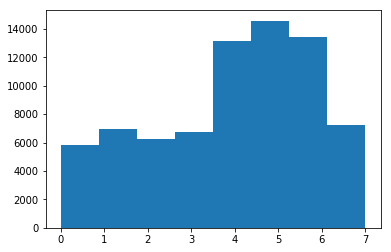

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y, bins=8)
plt.show()

In [68]:
# dictionary of clusters as keys and answers as values
cluster_assignments_dict = {}

for i in set(y):
    print("Cluster ", i)
    X_array = X.toarray()
    current_cluster_answers = [get_answer(X_array[x], words) for x in np.where(y == i)[0]]
    cluster_assignments_dict[i] = current_cluster_answers

Cluster  0
Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7


In [69]:
# show one cluster
cluster_pick = np.random.choice(len(set(y)))
print(f'Cluster {cluster_pick}')
cluster_assignments_dict[cluster_pick]

Cluster 4


['aid,associ,autr,certain,contr,dan,devr,doivent,fair,import,lois,mandat,mettr,moin,mêm,non,obligatoir,organis,oui,plus,polit,pouvoir,publiqu,question,rendr,respect,référendum,rôl,sais,servic,social,temp,vot,éduc,élus',
 'aid,associ,cas,cel,chaqu,chos,citoyen,devr,don,enfant,fair,faut,franc,grand,immigr,intérêt,mair,mettr,non,notr,obligatoir,oui,particip,pay,person,plus,pouvoir,proportionnel,publiqu,question,respect,référendum,san,sanction,servic,seul,societ,sort,supprim,vot,éduc,élect,élu',
 'associ,autr,chos,citoyen,civiqu,comm,commun,compt,consult,dan,devr,déput,enfant,fair,franc,immigr,local,lois,mair,nombr,non,oui,particip,plus,pouvoir,proportionnel,question,respect,référendum,san,supprim,vot,écol,élect,élus',
 'autr,bien,chos,citoyen,civiqu,comm,consult,dan,droit,déput,immigr,integr,intérêt,loi,nombr,non,oui,question,rôl,san,seul,sort,vot,écol,éduc,élus',
 'aid,an,appliqu,autr,cas,chaqu,chos,civiqu,commun,conseil,dan,droit,débat,entre,immigr,integr,intérêt,local,loi,mair,mandat,n

### Visualization

In [73]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=8, random_state=0).fit_transform(X)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 74054 samples in 0.141s...
[t-SNE] Computed neighbors for 74054 samples in 62.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 74054
[t-SNE] Computed conditional probabilities for sample 2000 / 74054
[t-SNE] Computed conditional probabilities for sample 3000 / 74054
[t-SNE] Computed conditional probabilities for sample 4000 / 74054
[t-SNE] Computed conditional probabilities for sample 5000 / 74054
[t-SNE] Computed conditional probabilities for sample 6000 / 74054
[t-SNE] Computed conditional probabilities for sample 7000 / 74054
[t-SNE] Computed conditional probabilities for sample 8000 / 74054
[t-SNE] Computed conditional probabilities for sample 9000 / 74054
[t-SNE] Computed conditional probabilities for sample 10000 / 74054
[t-SNE] Computed conditional probabilities for sample 11000 / 74054
[t-SNE] Computed conditional probabilities for sample 12000 / 74054
[t-SNE] Computed conditional probabilities for s

In [75]:
np.save("X_embedded.npy", X_embedded)
# X_embedded = np.load("X_embedded.npy")

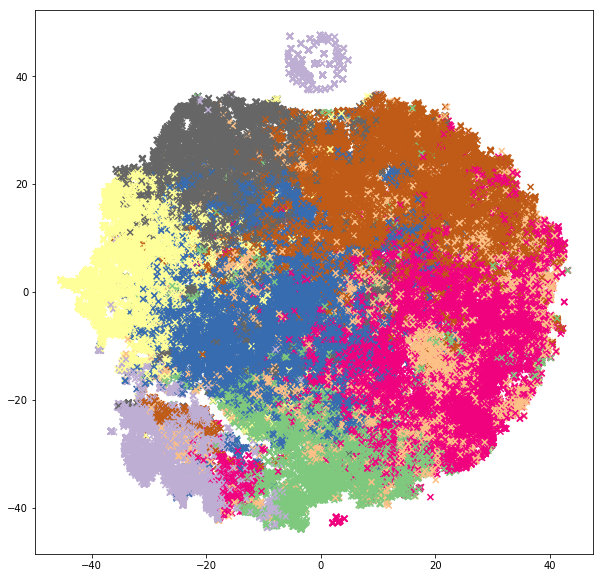

In [82]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker = "x", c = y, cmap="Accent")
plt.show()

In [15]:
# not necessary for classification
# labels from clustering
# transform labels to onehot code

# from sklearn.preprocessing import OneHotEncoder
# cat_encoder = OneHotEncoder()
# y_1hot = cat_encoder.fit_transform(y.reshape(-1,1))

/home/pepper/Documents/WorkSpace/python3environment/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Find the nearest neighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf.fit(X)

def print_nearest_neighbors(query_tf_idf, full_matrix, knn_model, k, words):
    """
    Inputs: a query tf_idf vector, the full matrix,
            the knn model, the number of neighbors, and the wordsb
    Prints the k nearest neighbors
    """
    distances, indices = knn_model.kneighbors(query_tf_idf, n_neighbors = k+1)
    nearest_neighbors = [get_answer(full_matrix[x], full_matrix) for x in indices.flatten()]
    
    for answer in xrange(len(nearest_neighbors)):
        if answer == 0:
            print('Query answer:', nearest_neighbors[answer])
        else:
            print(f'{answer}:', nearest_neighbors[answer])

In [ ]:
answer_id = np.random.choice(X.shape[0])
print_nearest_neighbors(X[answer_id], X, model_tf_idf, k=5)

## 3. Classification

In [21]:
# split into training set and test set
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y_1hot, test_size=0.2, random_state=42)

In [31]:
'''
Decision tree
'''
from sklearn import tree

clf_DT = tree.DecisionTreeClassifier()
clf_DT = clf_DT.fit(X_train, y_train.toarray())

In [32]:
clf_DT.score(X_test, y_test.toarray())

0.7352643305651205

In [ ]:
'''
when trying this, my computer broke down...
KNN
'''
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors = 4)
neigh.fit(X_train, y_train.toarray())
neigh.score(X_test, y_test.toarray())

In [ ]:
'''
This seems bad, maybe we should not use it
Naive Bayes
'''
from sklearn.naive_bayes import MultinomialNB

clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train.toarray())
clf_NB.score(X_test, y_test.toarray())

In [ ]:
'''
haven't tried this
train report
'''
from sklearn import metrics

y_predicted = neigh.predict(X)
print(metrics.classification_report(y, y_predicted))

#TODO
#Use the STEP1 cluster and the STEP2 cluster to predict the same
#block of data, use the result of the cluster as the correct one
#track the performance. Or you can change the parameters as you wish

#TODO IMPORTANT
#observe the clustering result and try to find a meaningful representation
#of each cluster like "people with a negative view", "people who don't believe
# democracy", etc. Like this our report will be more meaningful.